In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

(#2) [Path('/home/molly/data/mnist_png/testing'),Path('/home/molly/data/mnist_png/training')]

In [9]:
dls = DataBlock((ImageBlock(cls=PILImageBW),CategoryBlock),
                splitter=GrandparentSplitter('training','testing'),
                item_tfms=Resize(32),
                get_y=parent_label,
                get_items=get_image_files).dataloaders(path)

In [12]:
xs,ys=dls.one_batch()

First, what is a prediction? A prediction is some "guess" that ranges from 0-1, or 0-100%. We define that here as something that ranges from 0 to 1. (we leave out actual 0 for math reasons). 

In [23]:
preds=np.linspace(0.001,1.)

Lets look at log likelihood. $p(x)$ here is our label, and can be thought of as either 1 or 0. 
$$ H(p,q) = -\sum_{x\in X}{p(x)\log{q(x)}} $$

Lets graph this, notice near 0, or a completely wrong prediction the error explodes. 

In [276]:
F.nll_loss(pt,torch.ones(50).long(),reduction='none').shape

torch.Size([50])

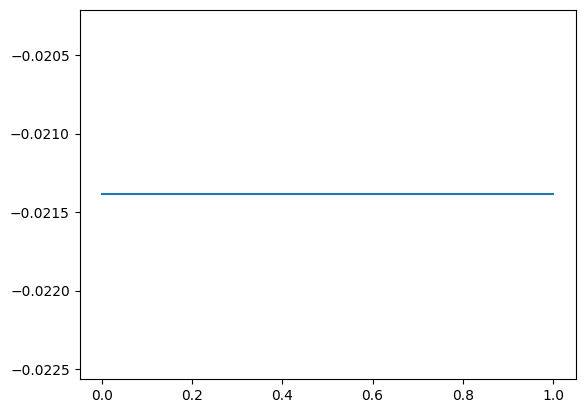

In [277]:
pt = torch.linspace(0.001,1.,50)[None].repeat(50,1)
plt.plot(torch.linspace(0.001,1.,50),F.nll_loss(pt,torch.ones(50).long(),reduction='none'))

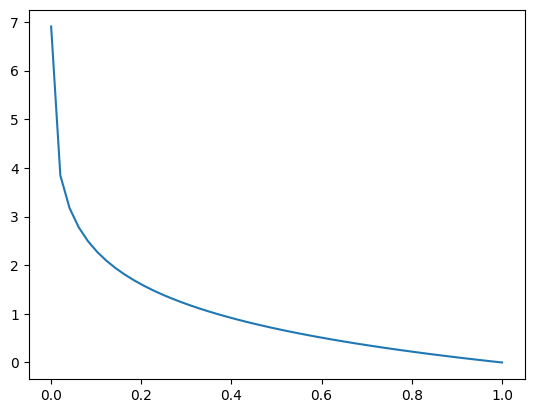

In [26]:
plt.plot(preds,-np.log(preds))

A quick note, cross entropy loss is also the sum of entropy and the KL divergence, KL divergence you will probably see in some diffusion papers. So whenever you see people minimizing the KL divergence, it is a proxy to attempting to minimize the log likelihood as well. 

$$ H(p,q) =  H(p)+D_{KL}(P\parallel Q)$$

$$ H(p,q) =  \sum_{x\in X}{p(x)\log{p(x)}}+\sum_{x\in X}{p(x)\log{\frac{p(x)}{q(x)}}}$$

$$ H(p,q) =  \sum_{x\in X}{p(x)\log{p(x)}}+\sum_{x\in X}{p(x)\log{p(x)}}-\sum_{x\in X}{p(x)\log{q(x)}}$$

$$p(x)=1$$

$$ H(p,q) =  \sum_{x\in X}{1\log{1}}+\sum_{x\in X}{1\log{1}}-\sum_{x\in X}{1\log{q(x)}}$$

$$ H(p,q) =  -\sum_{x\in X}{p(x)\log{q(x)}}$$

In [27]:
def entropy_plus_kl(p,q):
    return p*np.log(p)+p*np.log(p/q)

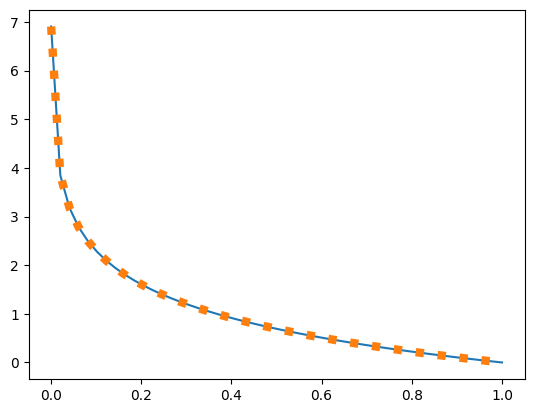

In [31]:
plt.plot(preds,-np.log(preds))
plt.plot(preds,entropy_plus_kl(1,preds),linewidth=6,linestyle=':')

Okay, now we know why we want to use cross-entropy. How do we generate values from 0 to 1? Well... lets use softmax. 

$$ Softmax(x_i)=\frac{e^{x_i}}{\sum_j{e^{x_j}}} $$

In [214]:
xss=array([-2,-1,0,1,2])
np.exp(xss)/np.exp(xss).sum()

array([0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865])

In [220]:
xss=array([-2,-1,0,1,2])
np.exp(xss),np.exp(xss)/np.exp(xss).sum()

(array([0.13533528, 0.36787944, 1.        , 2.71828183, 7.3890561 ]),
 array([0.01165623, 0.03168492, 0.08612854, 0.23412166, 0.63640865]))

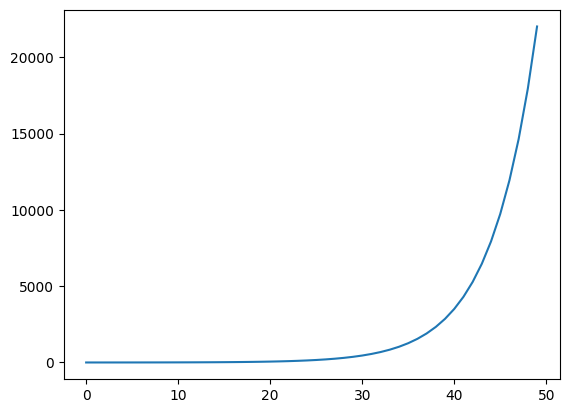

In [229]:
plt.plot(np.exp(np.linspace(0,10)))

In [206]:
xss=array([100,0,0,0,0])
np.exp(xss[0])/np.exp(xss).sum()

1.0

In [211]:
def relu(xss): return xss*(xss>0)
relu(xss)

array([0, 0, 0, 1, 2])

3

In [213]:
softmax(xss).sum()

1.0

In [34]:
def softmax(x): return np.exp(x)/np.exp(x).sum()

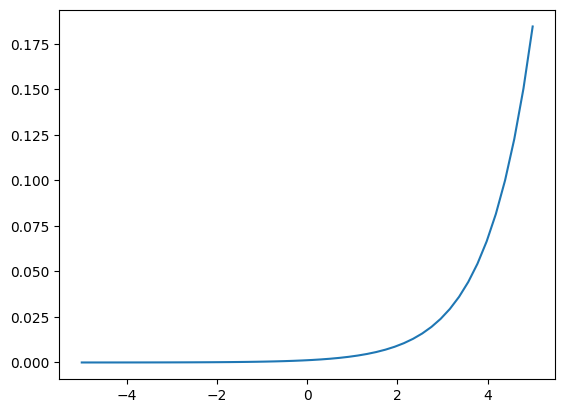

In [44]:
plt.plot(np.linspace(-5,5),softmax(np.linspace(-5,5)))

Softmax can be applied to the entire real numberline, giving our model flexibility in its output. It pushes up the highest values to be a significant portion of the final probability. 

It is probably important to pause here and look at what happens when crossentropy and softmax are combined. 

$$ H(p,q) = -\sum_{x\in X}{p(x)\log{q(x)}} $$

$$ Softmax(x_i)=\frac{e^{x_i}}{\sum_j{e^{x_j}}} $$

$$ H(p,q) = -\sum_{x\in X}{p(x)\log{\frac{e^{x_i}}{\sum_j{e^{x_j}}}}} $$

$$ \log\frac{x}{y} = \log x-\log y$$

$$ H(p,q) = -\sum_{x\in X}{p(x)\log{e^{x_i}}}+ \sum_{x\in X}{p(x)\log{(\sum_j{e^{x_j}})}}$$

$$ H(p,q) = -\sum_{x\in X}{p(x)x_i}+ \sum_{x\in X}{p(x)\log{(\sum_j{e^{x_j}})}}$$

Now, here comes the logsumexp trick. We can subtract a constant a from the exponent...

$$ H(p,q) = -\sum_{x\in X}{p(x)x_i}+ \sum_{x\in X}{p(x)\log{(\sum_j{e^ae^{x_j-a}})}}$$

$$ H(p,q) = -\sum_{x\in X}{p(x)x_i}+ \sum_{x\in X}{p(x)\log{(e^a\sum_j{e^{x_j-a}})}}$$

$$ H(p,q) = -\sum_{x\in X}{p(x)x_i}+ \sum_{x\in X}{p(x)a}+\sum_{x\in X}{p(x)\log{(\sum_j{e^{x_j-a}})}}$$

or... in the case of $p(x)=1$

$$ H(p,q) = -x_i+ a+\log{(\sum_j{e^{x_j-a}})}$$

In [230]:
def cross_soft(x):
    a=x.max()
    return -x+a+torch.log(torch.exp(x-a).sum())

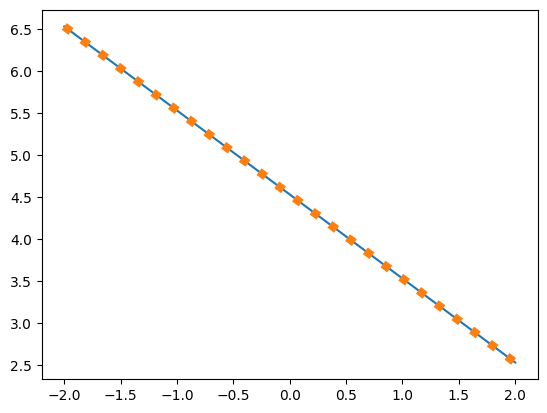

In [231]:
plt.plot(torch.linspace(-2,2,50),cross_soft(torch.linspace(-2,2,50)))
plt.plot(torch.linspace(-2,2,50),F.cross_entropy(torch.linspace(-2,2,50)[None].repeat(50,1),torch.arange(50),reduction='none'),linewidth=6,linestyle=':')

Now, lets rewrite cross_soft so it can take a target, and take a mean. 

In [93]:
def cross_soft2(x,targ,reduction='mean'):
    x=x[range(targ.shape[0]),targ]
    a=2
    if(reduction=='mean'):
        return (-x+a+torch.log(torch.exp(x-a).sum())).mean()
    else:
        return -x+a+torch.log(torch.exp(x-a).sum())

In [237]:
cross_soft2(torch.linspace(-2,2,50)[None].repeat(50,1),torch.arange(50))

tensor(4.5290)

In [238]:
F.cross_entropy(torch.linspace(-2,2,50)[None].repeat(50,1),torch.arange(50),)

tensor(4.5290)

Okay lets try a derivative ... 

$$ H(p,q) = -x_i+ a+\log{(\sum_j{e^{x_j-a}})}$$

In [241]:
torch.linspace(-2,2,50)[None].repeat(50,1)

tensor([[-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        ...,
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000],
        [-2.0000, -1.9184, -1.8367,  ...,  1.8367,  1.9184,  2.0000]])

$$ \frac{H(p,q)}{dX} = -x_i+ a+\log{(\sum_j{e^{x_j-a}})}$$

$$ \frac{dH(p,q)}{dx_k} = -1+ 0+\frac{e^{x_k-a}}{\sum_j{e^{x_j-a}}}$$

j does not equal i

$$ \frac{dH(p,q)}{dx_k} = 0+ 0+\frac{e^{x_k-a}}{\sum_j{e^{x_j-a}}}$$ 

$$ \frac{dH(p,q)}{dx_k} = -y+softmax(x)$$ 

In [250]:
def cross_soft2_grad(x,targ,reduction='mean'):
    a=x.max()
    return ((torch.exp(x-a)/(torch.exp(x-a).sum(1)))-F.one_hot(targ))/targ.shape[0]

In [251]:
cross_soft2_grad(torch.linspace(-2,2,50)[None].repeat(50,1),torch.arange(50))

tensor([[-1.9971e-02,  3.1692e-05,  3.4388e-05,  ...,  1.3545e-03,
          1.4697e-03,  1.5947e-03],
        [ 2.9208e-05, -1.9968e-02,  3.4388e-05,  ...,  1.3545e-03,
          1.4697e-03,  1.5947e-03],
        [ 2.9208e-05,  3.1692e-05, -1.9966e-02,  ...,  1.3545e-03,
          1.4697e-03,  1.5947e-03],
        ...,
        [ 2.9208e-05,  3.1692e-05,  3.4388e-05,  ..., -1.8646e-02,
          1.4697e-03,  1.5947e-03],
        [ 2.9208e-05,  3.1692e-05,  3.4388e-05,  ...,  1.3545e-03,
         -1.8530e-02,  1.5947e-03],
        [ 2.9208e-05,  3.1692e-05,  3.4388e-05,  ...,  1.3545e-03,
          1.4697e-03, -1.8405e-02]])

In [255]:
xs=torch.linspace(-2,2,50)[None].repeat(50,1).requires_grad_()
loss=F.cross_entropy(xs,torch.arange(50),reduction='mean')
loss.backward()
((xs.grad-cross_soft2_grad(torch.linspace(-2,2,50)[None].repeat(50,1),torch.arange(50))).abs()<0.00000001).all()

tensor(True)

$$ y_{ik}=\sum_j{x_{ij}w_{jk}+b_k} $$

$$ \frac{dY}{dX} =X\frac{dW}{dX}+\frac{dX}{dX}W^T + \frac{dB}{dX}$$

$$ \frac{dY}{dX} =W^T $$

$$ \frac{dY}{dW} = X $$

$$ \frac{dY}{dB} =1 $$

$$ y_{ik}=\sum_j{w_{ij}x_{jk}} $$

$$ \frac{dy_{ik}}{dx_{ij}}=\sum_j{0x_{jk}+w_{ij}\frac{dx_{jk}}{dx_{jk}}} $$